<a href="https://colab.research.google.com/github/cvecchi/Corrado/blob/master/Diagnosi_Covid_on_RXT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

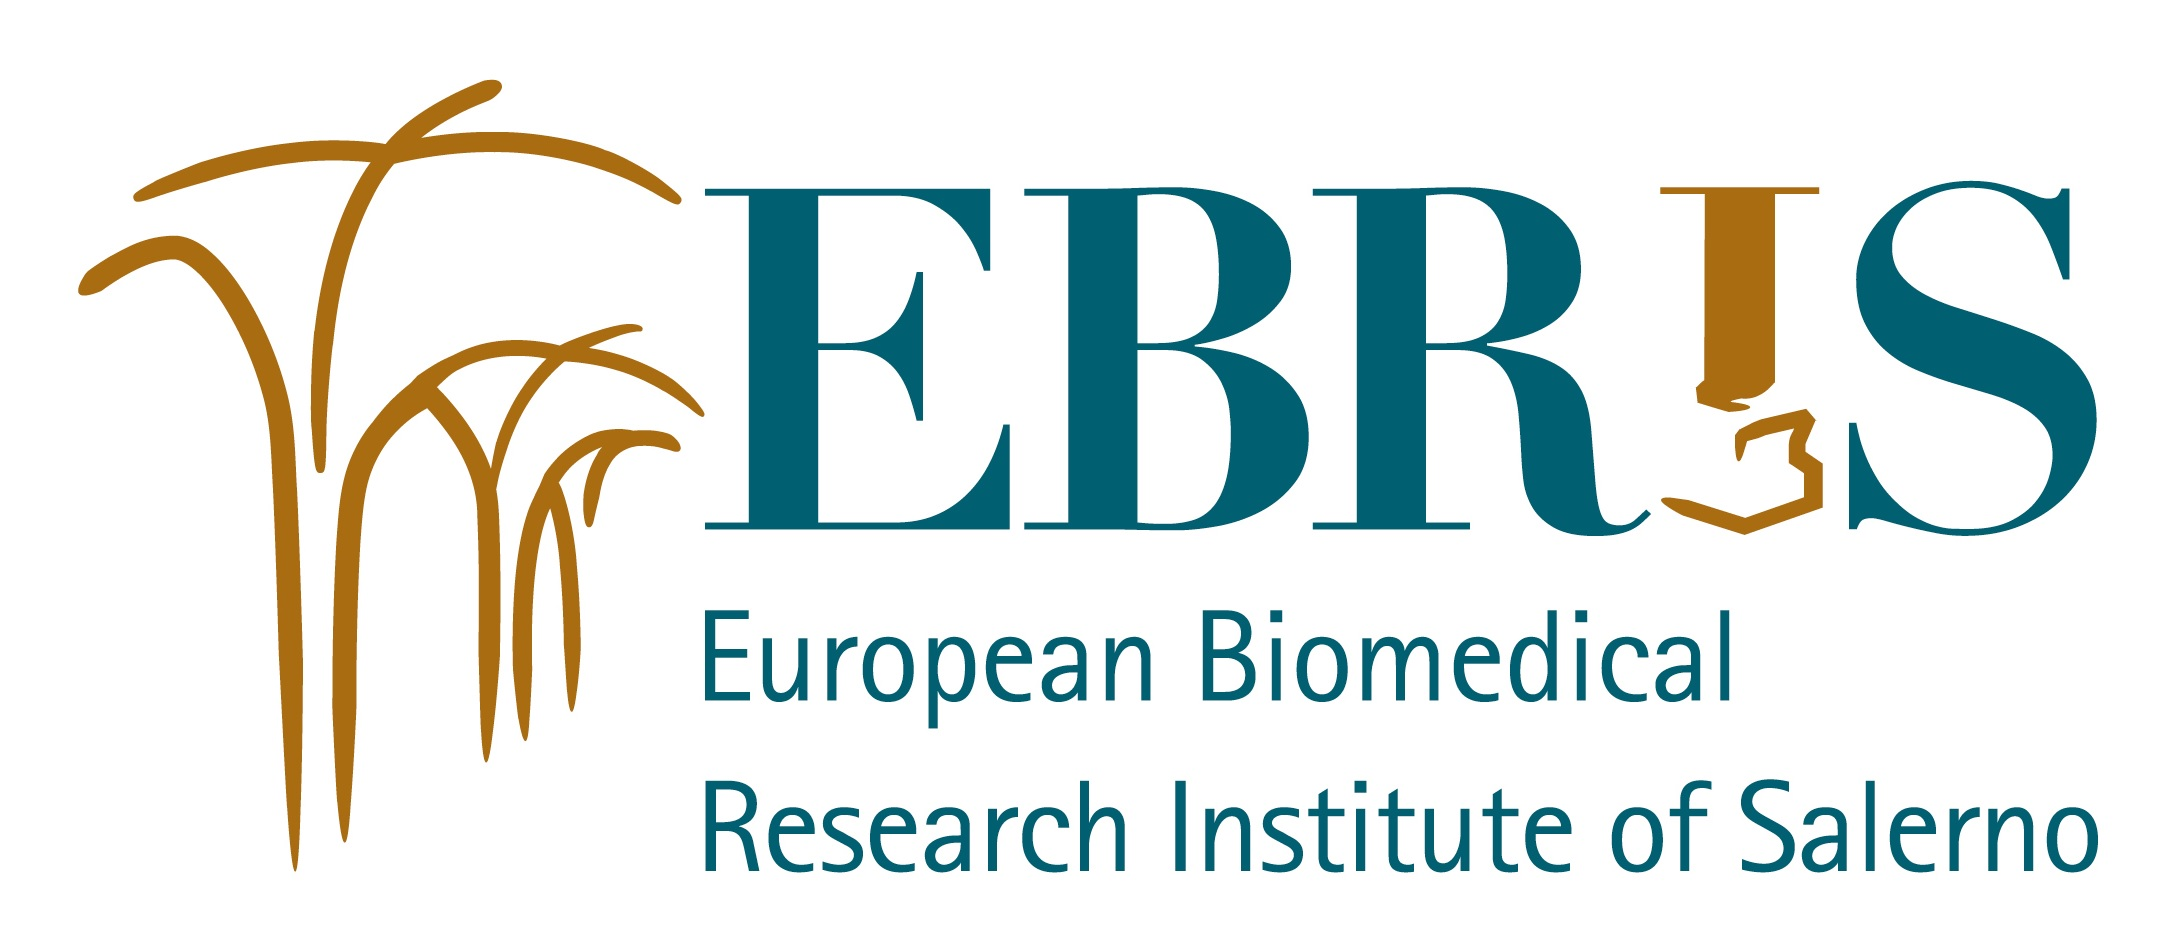
# RETE NEURALE CONVOLUZIONALE PER PREDIZIONE COVID-19 TRAMITE IMMAGINE RICAVATA DA RADIOGRAFIA POSTURO-ANTERIORE

Ebris Foundation 1 Settembre 2020   C.Vecchi

## LE DIPENDENZE ##

In [ ]:
import os
import numpy as np
 
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
 
from shutil import copyfile
from random import shuffle
 
from sklearn.model_selection import train_test_split
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dropout
from sklearn.metrics import confusion_matrix
 
from math import sqrt

## DATASET ##


In [ ]:
if(not os.path.isdir("dataset")):  # se non esiste crea le subdirectory
  os.mkdir("dataset/")
  os.mkdir("dataset/covid")
  os.mkdir("dataset/normal")


#### COSTANTI

In [ ]:
IMG_SIZE = (200, 200)
BATCH_SIZE = 32

#### RADIOGRAFIE DI PAZIENTI CON COVID-19

In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git    #clona in locale il contenuto del portale

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 3668, done.
remote: Total 3668 (delta 0), reused 0 (delta 0), pack-reused 3668
Receiving objects: 100% (3668/3668), 632.85 MiB | 26.93 MiB/s, done.
Resolving deltas: 100% (1460/1460), done.
Checking out files: 100% (1164/1164), done.


In [ ]:
df = pd.read_csv("covid-chestxray-dataset/metadata.csv") #leggi il contenuto del metadata per identificare le immagini Posturo-Anteriore con Covid-19
df.head()

In [ ]:
df = df[(df["finding"]== "Pneumonia/Viral/COVID-19") & (df["view"]== "PA")] #scelgo le linee con finding=COVID-19 e view=PA
df.head()


In [ ]:
imgs_covid = list(df["filename"])  #creo la variabile
imgs_covid[:10]

['auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg',
 'nejmc2001573_f1a.jpeg',
 'nejmc2001573_f1b.jpeg',
 'lancet-case2a.jpg',
 'lancet-case2b.jpg',
 '1-s2.0-S0140673620303706-fx1_lrg.jpg',
 'nCoV-radiol.2020200269.fig1-day7.jpeg']

In [ ]:
imgs_covid_count = len(imgs_covid) #vedo quanti file ho covid-19 e PA
imgs_covid_count


196

In [ ]:
def copy_samples(imgs_list, imgs_path, cls):  #definisco una finzione copy_samples che mi servirà ora e in futuro
  for img in imgs_list:
    copyfile(imgs_path+img, "dataset/"+cls+"/"+img)

In [ ]:
copy_samples(imgs_covid, "covid-chestxray-dataset/images/", "covid")

#### RADIOGRAFIE PAZIENTI SANI 

In [ ]:
!pip install kaggle   #installo kaggle

In [ ]:
user = "corradovecchi"                                          #vado sulla mia utenza kaggle
key = "08ef2d063b2d6e5b4343f17d4c99625b"
if '.kaggle' not in os.listdir('/root'):
  !mkdir ~/.kaggle
!touch /root/.kaggle/kaggle.json
!chmod 666 /root/.kaggle/kaggle.json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write('{"username":"%s","key":"%s"}' % (user, key))
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia  #scarico il database di immagini di pazienti normali e con polmonite ma non covid-19

100% 2.28G/2.29G [00:39<00:00, 48.5MB/s]
100% 2.29G/2.29G [00:39<00:00, 62.4MB/s]


In [ ]:
!unzip -q chest-xray-pneumonia.zip

In [ ]:
imgs_normal = os.listdir("chest_xray/train/NORMAL/")  #prendo la dir NORMAL
imgs_normal[:10]

['IM-0545-0001.jpeg',
 'IM-0176-0001.jpeg',
 'IM-0201-0001.jpeg',
 'IM-0671-0001.jpeg',
 'NORMAL2-IM-1293-0001.jpeg',
 'IM-0359-0001.jpeg',
 'NORMAL2-IM-0555-0001-0001.jpeg',
 'NORMAL2-IM-0911-0001.jpeg',
 'NORMAL2-IM-0933-0001.jpeg',
 'NORMAL2-IM-0829-0001.jpeg']

In [ ]:
shuffle(imgs_normal)
imgs_normal = imgs_normal[:imgs_covid_count]

In [ ]:
len(imgs_normal)

196

In [ ]:
copy_samples(imgs_normal,"chest_xray/train/NORMAL/", "normal" )  # copio nella mia normal


#### PREPROCESSING DELLE IMMAGINI

In [ ]:
X = []
y = []
z =[]
encoding =[("normal", 0), ("covid", 1)]

for folder, label in encoding:
  current_folder = "dataset/"+folder+"/"
  for img_name in os.listdir(current_folder):
    img = cv2.imread(current_folder+img_name, cv2.IMREAD_GRAYSCALE)
    img = cv2.equalizeHist(img) #Normalizzazione delle immagini equalizza Hist
    img = cv2.resize(img, IMG_SIZE)/255.  #ridimensionamo l'immagine 200,200 e normalizziamo i pixel 0-255 verso 0-1
    X.append(img) #metto tutto in X
    
    z.append(img_name) #label in Y
    y.append(label)#label in Y
 
X= np.array(X) #convertiamo in array np
y= np.array(y)

  


In [ ]:
 len(z)

392

In [ ]:
X.shape

(392, 200, 200)

In [ ]:
y.shape #vettore unidimensionale

(392,)

In [ ]:
def show_samples(X):
  fig = plt.figure()
  for i in range(X.shape[0]):
    plot = fig.add_subplot(1,X.shape[0], i+1) #metto le immagini in una griglia con una riga e lunga quanto le immagini
    plt.imshow(X[i], cmap="gray")
    #plt.imshow(X_test[i].reshape(200, 200), cmap="gray")
    plt.axis("off") #disattivo gli assi


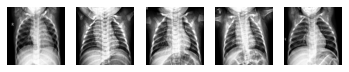

In [ ]:
show_samples(X[:5])  #Stampo le prime 5

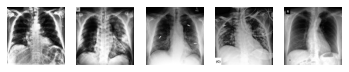

In [ ]:
show_samples(X[-6:-1]) #prima metà caso negativo e seconda metà positivo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)  # per non incappare in cicli mescoliamo con train_test_split
#Paramentri array X array target, dimensione del set test ossia 25% immagini, parametro stratify per assicurarci che le classi siano ben distribuite

In [ ]:
X_train.shape #ristampiamo le feature

(294, 200, 200)

In [ ]:
X_test.shape

(98, 200, 200)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2],1) #aggiungere un'altra dimentione pari al numero di canali delle immagini (1perche b/w)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)#aggiungere un altra dimensione pari al numero di canali delle immagini ossia 1 perchè BW

In [ ]:
X_train.shape 
#Necessario aumentare di una dimensione per rete neurale tensorflow


(294, 200, 200, 1)

In [ ]:
X_test.shape

(98, 200, 200, 1)

### DATA AUGMENTATION

In [ ]:
datagen = ImageDataGenerator(
    rotation_range = 15,
    brightness_range = [0.2, 1.0]
)
# generiamp più immagini partendo da quelle che abbiamo con generatori di keras ruotando di 15 gradi e variando la luminosità
train_generator = datagen.flow(
      X_train,
      y_train,
      batch_size=BATCH_SIZE
)
#creaimo il generatore per l'addestramento numero di immagini in BATCH_SIZE

## ADDESTRAMENTO DELLA RETE NEURALE CONVOLUZIONALE

In [ ]:
model = Sequential() ## creiamo modello vuoto
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)))
# Architettura: I strato convol.con 32 kit, kernel 3x3, attiv rectified line unit, sul prim strato devo definire la dimensione
model.add(AveragePooling2D(pool_size=2))
#model.add(Dropout(0.4))
model.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
# un altro strato 
model.add(AveragePooling2D(pool_size=2))
#model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(64, activation="relu"))  #strato con 64 neuroni
#model.add(Dropout(0.4))
model.add(Dense(1,activation="sigmoid")) #ultimo nodo unico strato binario vero falso
# Utilizziamo Keras di Tensorflow Conv2d per rete convoluzionale

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 32)      320       
_________________________________________________________________
average_pooling2d (AveragePo (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 32)        9248      
_________________________________________________________________
average_pooling2d_1 (Average (None, 48, 48, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                4718656   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"]) #classificazione binaria optimizzazione con learning rate adattivo
# configuriamo l'addestramento con costo binario entorpy con learnig gain adattivo e accuracy per addestramento

In [ ]:
model.fit(train_generator, epochs=50, steps_per_epoch=X_train.shape[0]//BATCH_SIZE) # ADDESTRAMENTO con 50 Epoche


Epoch 1/50
9/9 [==============================] - 1s 80ms/step - loss: 146.9644 - accuracy: 0.5305
Epoch 2/50
9/9 [==============================] - 1s 94ms/step - loss: 1.6252 - accuracy: 0.5458
Epoch 3/50
9/9 [==============================] - 1s 85ms/step - loss: 0.6908 - accuracy: 0.5115
Epoch 4/50
9/9 [==============================] - 1s 89ms/step - loss: 0.5603 - accuracy: 0.6985
Epoch 5/50
9/9 [==============================] - 1s 88ms/step - loss: 0.4576 - accuracy: 0.9275
Epoch 6/50
9/9 [==============================] - 1s 89ms/step - loss: 0.4173 - accuracy: 0.9427
Epoch 7/50
9/9 [==============================] - 1s 86ms/step - loss: 0.3957 - accuracy: 0.9427
Epoch 8/50
9/9 [==============================] - 1s 89ms/step - loss: 0.5350 - accuracy: 0.9313
Epoch 9/50
9/9 [==============================] - 1s 87ms/step - loss: 0.3608 - accuracy: 0.9847
Epoch 10/50
9/9 [==============================] - 1s 87ms/step - loss: 0.3529 - accuracy: 0.9771
Epoch 11/50
9/9 [==========

In [ ]:
metrics_train= model.evaluate(X_train, y_train)
metrics_test= model.evaluate(X_test, y_test)
print("Train accuracy = %.4f - Train loss = %.4f" % (metrics_train[1], metrics_train[0]))
print("Test accuracy = %.4f - Test loss = %.4f" % (metrics_test[1], metrics_test[0]))

4/4 [==============================] - 0s 16ms/step - loss: 0.6236 - accuracy: 0.8061
Train accuracy = 0.8571 - Train loss = 0.6180
Test accuracy = 0.8061 - Test loss = 0.6236


In [ ]:
y_pred = model.predict_classes(X_test)
y_pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
    

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[49,  0],
       [19, 30]])

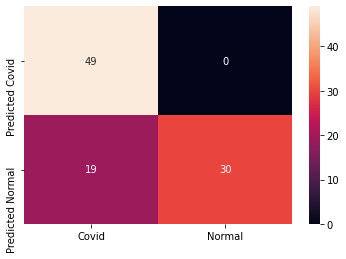

In [ ]:
df_cm = pd.DataFrame(cm, index=["Predicted Covid", "Predicted Normal"], columns=["Covid","Normal"])
sn.heatmap(df_cm, annot=True)

### COVID-19 o Polmonite?

In [ ]:
if(not os.path.isdir("dataset/pneumonia/")):
  os.mkdir("dataset/pneumonia")


In [ ]:
imgs_pneumonia = os.listdir("chest_xray/train/PNEUMONIA/") #listo i file
shuffle(imgs_pneumonia) #esplodiamo le immagini
imgs_pneumonia = imgs_pneumonia[:imgs_covid_count]  #prendiamone un numero uguali a quelle del covid
copy_samples(imgs_pneumonia, "chest_xray/train/PNEUMONIA/", "pneumonia") #copio le immagini nella dir mia


In [ ]:
X_pneumonia = []   #inizializzo il vettore
for img_name in os.listdir("dataset/pneumonia"):
  img = cv2.imread("dataset/pneumonia/"+img_name, cv2.IMREAD_GRAYSCALE) #Leggo l'immagine in biano e nero
  img = cv2.equalizeHist(img) # applico equalizzazione dell'istogramma per correggere luninosità
  img = cv2.resize(img, IMG_SIZE)/255. #ridimensioniamo l'immagine come le altre dell'addestramento e normalizziamo
  X_pneumonia.append(img)# appendo
X_pneumonia = np.array(X_pneumonia) #converto in array np


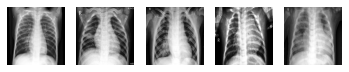

In [ ]:
show_samples(X_pneumonia[:5]) #stampo le prime 5 immagini

In [ ]:
X_pneumonia.shape #controllo la dimensione dell'array

(196, 200, 200)

In [ ]:
X_pneumonia = X_pneumonia.reshape(X_pneumonia.shape[0],X_pneumonia.shape[1],X_pneumonia.shape[2],1)
#per passare array alla rete dobbiamo dobbiamo anche dire il numero di canali essendo bianco e nero è 1


In [ ]:
X_pneumonia.shape #ricontrollo la dimensione dell'array

(196, 200, 200, 1)

In [ ]:
y_pred = model.predict_classes(X_pneumonia) # Facciamo una predizione 0 se negativo 1 se positivo
y_pred

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
    

In [ ]:
misclassified_count = y_pred[y_pred==1].shape[0] #vediamo quanti ne ha cannati su 180 nel falsi positivi
misclassified_count

0

In [ ]:
pneumonia_samples_count = X_pneumonia.shape[0] #numero esempi che avevamo
pneumonia_samples_count #vediamo

196

In [ ]:
misclassified_percentage = misclassified_count*100/pneumonia_samples_count #facciAMO IN PERCENTUALE
misclassified_percentage

0.0

In [ ]:
misclassified_percentage = round(misclassified_count*100/pneumonia_samples_count,2) #arrotondo
print("Pazienti con polmonite classificati come affetti da COVID-19 = %d/%d(%.2f%%)" % (misclassified_count, pneumonia_samples_count,misclassified_percentage))

Pazienti con polmonite classificati come affetti da COVID-19 = 0/196(0.00%)


## TESTIAMO LA RETE NEURALE

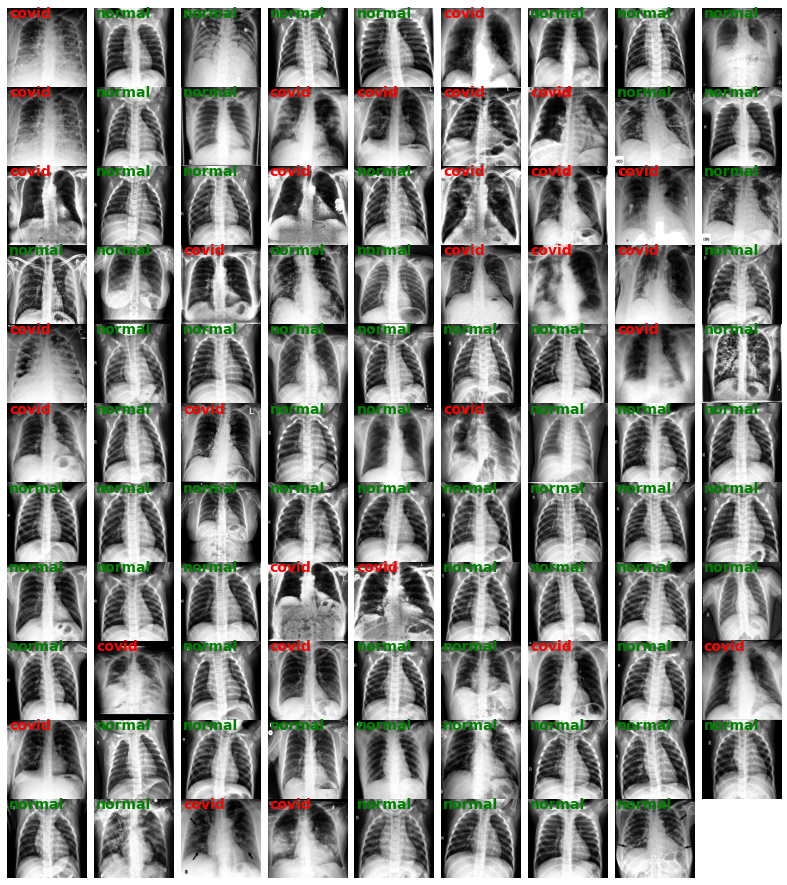

In [ ]:
labels = ["normal", "covid"]
colors = ["green", "red"]

pred = model.predict_classes(X_test)

fig = plt.figure(figsize=(14, 16))
fig.subplots_adjust(wspace=0, hspace=0)

n_cols = int(sqrt(X_test.shape[0]))
n_rows = X_test.shape[0]//n_cols+1
for i in range(X_test.shape[0]):

  plot = fig.add_subplot(n_rows, n_cols, i+1)
  plt.imshow(X_test[i].reshape(200, 200), cmap="gray")
  class_index = pred[i][0]
  plt.text(5, 25, labels[class_index], fontsize=14, color=colors[class_index], fontdict={'weight':'bold'})
  plt.axis('off')